# Project 03. Regression - Bycicle rental forecast

## 1. Defining the goal of the project 

The goal of this project is to predict/forecast the total number of rented bycicles in each hour based on time and weather features, optimizing the accuracy of the model for RMSLE, using Kaggle's "Bike Sharing Demand" dataset that provides hourly rental data spanning two years.

The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We predict the total count of bikes rented in each hour covered by the test set, using only information available prior to the rental period.

More information on the data fields: 

https://www.kaggle.com/c/bike-sharing-demand/data


## 2. Importing Libraries

In [259]:
# Importing Libraries

# EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Feature Selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

# Metrics
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

## 3. Getting the data

In [5]:
# loading datasets for training, testing and submission. parsing the column 'dates' and turning it into datetime
df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)
df_submission = pd.read_csv('data/sampleSubmission.csv', index_col=0, parse_dates=True)

In [6]:
df_train.shape, df_test.shape, df_submission.shape

((10886, 11), (6493, 8), (6493, 1))

In [7]:
df_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [8]:
df_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


In [9]:
df_submission

,count
datetime,
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0
2011-01-20 03:00:00,0
2011-01-20 04:00:00,0
...,...
2012-12-31 19:00:00,0
2012-12-31 20:00:00,0
2012-12-31 21:00:00,0


## 4. Exploratory Data Analysis

### 4.1. The variables of the dataset


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


    datetime - date and hour
    season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
    holiday - the day considered as bank holiday
    workingday - neither weekend nor holiday
    weather
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp - temperature in Celsius
    atemp - "feels like" temperature in Celsius
    humidity - relative humidity
    windspeed - wind speed
    casual - number of non-registered user rentals initiated
    registered - number of registered user rentals initiated
    count - number of total rentals


### 4.2. Extracting datetime features from the DatetimeIndex

In [11]:
# Extracting hour, weekday, month and year from datetime 
df_train['hour'] = df_train.index.hour
df_train['weekday'] = df_train.index.weekday
df_train['month'] = df_train.index.month
df_train['year'] = df_train.index.year

In [12]:
df_train.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011


### 4.3. Visualizing the relationships between single features and the target variable

In [13]:
# aggregating data per month for visualization
resampled = df_train.resample('M').sum()
# resampled

<AxesSubplot:xlabel='workingday', ylabel='count'>

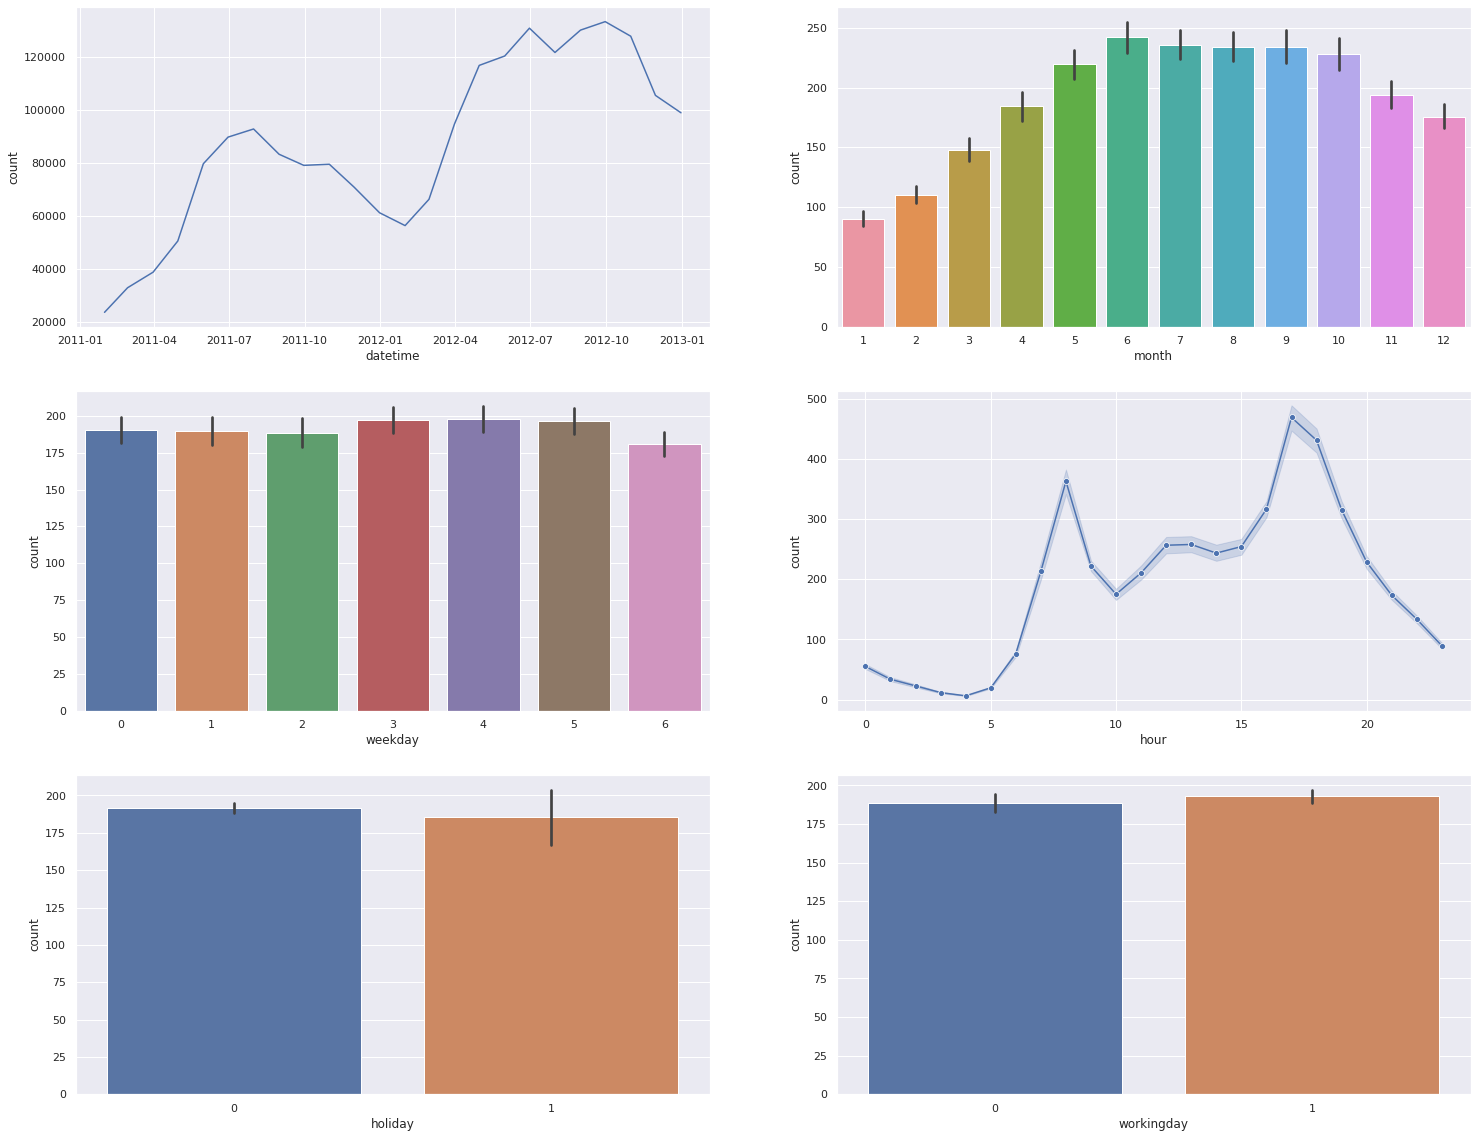

In [14]:
# plotting time related variables 
plt.figure(figsize=(25,20))
sns.set_theme()
plt.subplot(3,2,1)
sns.lineplot(data=resampled, x=resampled.index, y='count')
plt.subplot(3,2,2)
sns.barplot(data=df_train, x='month',y='count',estimator=np.mean)
plt.subplot(3,2,3)
sns.barplot(data=df_train,x='weekday',y='count',estimator=np.mean)
plt.subplot(3,2,4)
sns.lineplot(data=df_train,x='hour',y='count', marker='o', estimator=np.mean)
plt.subplot(3,2,5)
sns.barplot(data=df_train, x="holiday", y="count", estimator=np.mean)
plt.subplot(3,2,6)
sns.barplot(data=df_train, x="workingday", y="count",  estimator=np.mean)


<AxesSubplot:xlabel='windspeed', ylabel='count'>

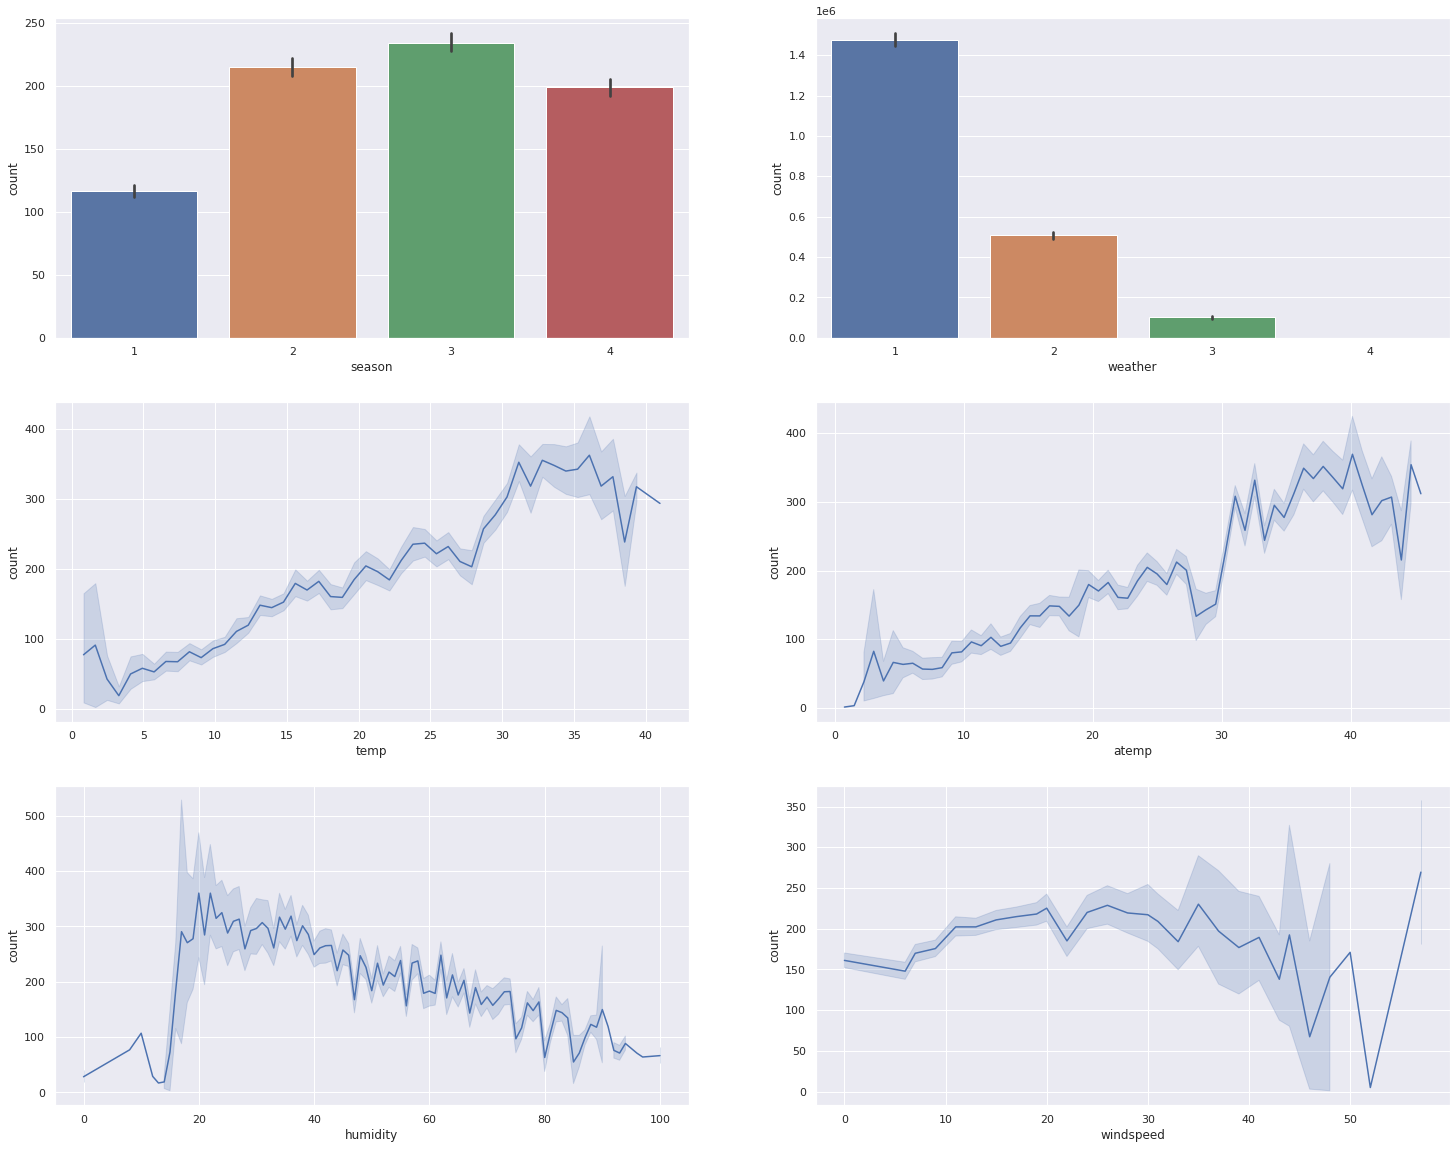

In [15]:
# Plotting weather related variables
plt.figure(figsize=(25,20))
sns.set_theme()
plt.subplot(3,2,1)
sns.barplot(x="season", y="count", data=df_train, estimator=np.mean)
plt.subplot(3,2,2)
sns.barplot(x="weather", y="count", data=df_train, estimator=np.sum)
plt.subplot(3,2,3)
sns.lineplot(x="temp", y="count", data=df_train)
plt.subplot(3,2,4)
sns.lineplot(x="atemp", y="count", data=df_train) 
plt.subplot(3,2,5)
sns.lineplot(x="humidity", y="count", data=df_train) 
plt.subplot(3,2,6)
sns.lineplot(x="windspeed", y="count", data=df_train)

### 4.4. Correlation / Multicollinearity

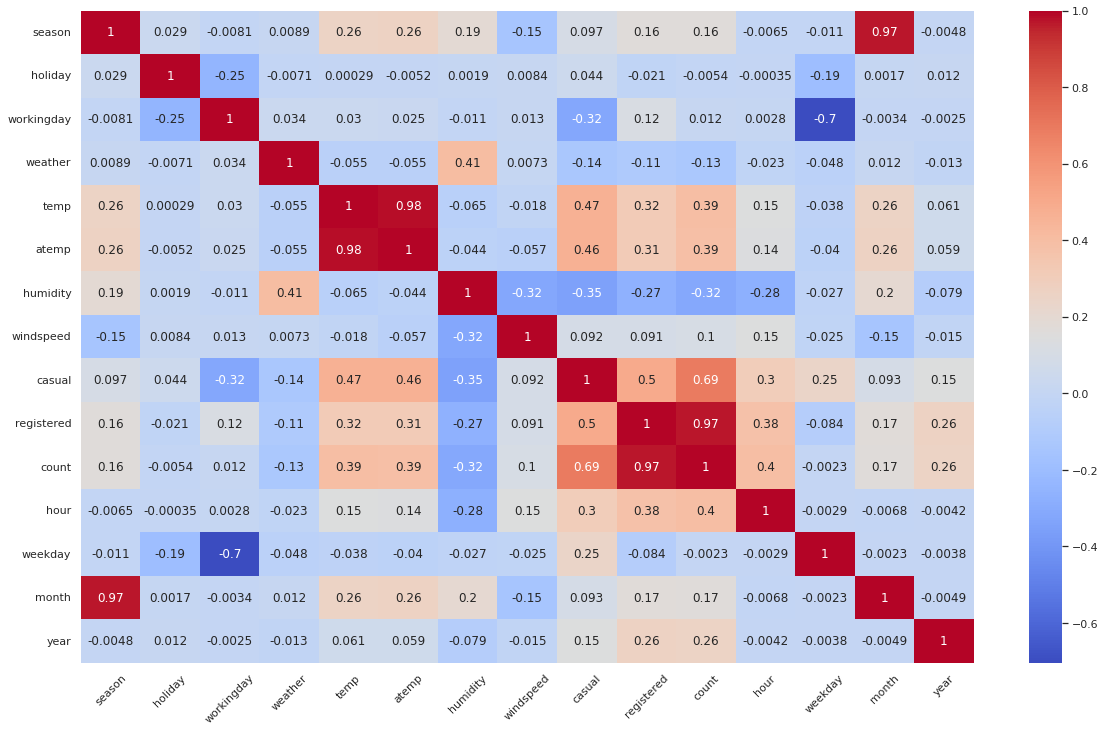

In [16]:
# Visualizing multicollinearity with Correlation Matrix
plt.figure(figsize=(20,12)) 
ax = sns.heatmap(df_train.corr(),annot=True, cmap='coolwarm')
ax.tick_params(axis='x', rotation=45)

### 4.5. Feature Selection with Variance Inflation Factor 

In [17]:
df_train_vif = df_train.drop(['casual', 'registered', 'count'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_train_vif.columns

In [18]:
vif_data

,feature
0,season
1,holiday
2,workingday
3,weather
4,temp
5,atemp
6,humidity
7,windspeed
8,hour
9,weekday


In [19]:
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_train_vif.values, i)
                          for i in range(len(df_train_vif.columns))]
print(vif_data)

       feature         VIF
0       season  109.474112
1      holiday    1.565106
2   workingday    9.064293
3      weather    7.508942
4         temp  276.719498
5        atemp  315.197703
6     humidity   17.493027
7    windspeed    4.161167
8         hour    4.247420
9      weekday    9.196941
10       month   83.524540
11        year   67.055738


In [20]:
df_train_vif = df_train.drop(['casual', 'registered', 'count', 'atemp'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_vif.values, i)
                          for i in range(len(df_train_vif.columns))]
print(vif_data)

       feature         VIF
0       season  109.473980
1      holiday    1.555623
2   workingday    8.995152
3      weather    7.501700
4         temp    8.588453
5     humidity   17.444028
6    windspeed    3.992635
7         hour    4.242934
8      weekday    9.130404
9        month   83.521942
10        year   63.049357


In [21]:
df_train_vif = df_train.drop(['casual', 'registered', 'count', 'atemp', 'season'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_vif.values, i)
                          for i in range(len(df_train_vif.columns))]
print(vif_data)

      feature        VIF
0     holiday   1.542563
1  workingday   8.994986
2     weather   7.501312
3        temp   8.578762
4    humidity  17.420442
5   windspeed   3.991422
6        hour   4.242130
7     weekday   9.129221
8       month   5.245527
9        year  59.644012


In [22]:
df_train_vif = df_train.drop(['casual', 'registered', 'count', 'atemp', 'season', 'year'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_vif.values, i)
                          for i in range(len(df_train_vif.columns))]
print(vif_data)

      feature        VIF
0     holiday   1.293959
1  workingday   5.460216
2     weather   7.469605
3        temp   7.728628
4    humidity  12.879300
5   windspeed   3.464645
6        hour   3.925416
7     weekday   5.321123
8       month   5.203902


In [23]:
df_train_vif = df_train.drop(['casual', 'registered', 'count', 'atemp', 'season', 'year', 'humidity'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = df_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_train_vif.values, i)
                          for i in range(len(df_train_vif.columns))]
print(vif_data)

      feature       VIF
0     holiday  1.229364
1  workingday  4.629651
2     weather  5.199962
3        temp  7.637529
4   windspeed  3.386943
5        hour  3.845362
6     weekday  4.411835
7       month  4.771238


Result of VIF: drop 'atemp', 'season', 'year', 'humidity'

### 4.6. Assigning X and y for training

In [24]:
# we want to predict count, so this will be y. We also drop casual and registered from X, since their sum is the number we want to predict. 
# 'season', 'atemp' is dropped due to VIF
X = df_train.drop(['casual','registered', 'count', 'season', 'atemp'], axis=1)
y = df_train['count']

### 4.7.  Train-test split X and y data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [26]:
X_train

,holiday,workingday,weather,temp,humidity,windspeed,hour,weekday,month,year
datetime,,,,,,,,,,
2011-06-18 19:00:00,0,0,2,30.34,51,7.0015,19,5,6,2011
2012-09-08 17:00:00,0,0,3,23.78,83,12.9980,17,5,9,2012
2011-05-01 17:00:00,0,0,2,19.68,82,16.9979,17,6,5,2011
2012-11-19 00:00:00,0,1,1,14.76,66,15.0013,0,0,11,2012
2011-05-16 09:00:00,0,1,1,24.60,69,12.9980,9,0,5,2011
...,...,...,...,...,...,...,...,...,...,...
2011-02-08 03:00:00,0,1,3,11.48,93,11.0014,3,1,2,2011
2012-01-12 11:00:00,0,1,2,13.94,81,7.0015,11,3,1,2012
2012-06-13 23:00:00,0,1,1,25.42,50,19.0012,23,2,6,2012


In [27]:
y_train

datetime
2011-06-18 19:00:00    326
2012-09-08 17:00:00    171
2011-05-01 17:00:00    196
2012-11-19 00:00:00     27
2011-05-16 09:00:00    194
                      ... 
2011-02-08 03:00:00      1
2012-01-12 11:00:00    119
2012-06-13 23:00:00    153
2011-04-02 14:00:00    190
2011-04-10 08:00:00     55
Name: count, Length: 8708, dtype: int64

### 4.8. Checking Missing Values:

In [28]:
X.isna().sum()

holiday       0
workingday    0
weather       0
temp          0
humidity      0
windspeed     0
hour          0
weekday       0
month         0
year          0
dtype: int64

There are no missing values, therefore no need for dropna or impute

## 5. Feature Engineering with ColumnTransformer

    
    holiday     0, 1 OneHotEncoder
    workingday 0, 1 OneHotEncoder
    weather     1-3 OneHotEncoder    
    temp        cont. numerical Scaling
    humidity    cont. numerical Scaling
    windspeed   cont. numerical Scaling
    hour        0-23 Scaling
    weekday     0-6 OneHotEncoder
    month       0-11 OneHotEncoder
    year        2011, 2012 OneHotEncoder
   
    OneHotEncoder: holiday, workingday, weather, weekday, month, year
    MinMaxScaler: temp, humidity, windspeed, hour

In [35]:
column_transformer = ColumnTransformer([
    ('cat_ohe', OneHotEncoder(handle_unknown = 'ignore'), ['holiday', 'workingday', 'weather', 'weekday', 'month', 'year']),
    ('num_scaler', MinMaxScaler(), ['temp', 'humidity', 'windspeed', 'hour']) 
])

In [36]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['holiday', 'workingday', 'weather', 'weekday',
                                  'month', 'year']),
                                ('num_scaler', MinMaxScaler(),
                                 ['temp', 'humidity', 'windspeed', 'hour'])])

In [37]:
X_train_fe = column_transformer.transform(X_train)
X_test_fe = column_transformer.transform(X_test)

## 6. Training Models

### 6.1. Linear Regression 

In [38]:
# Poission Regression is a linear regression model that was designed for handling count data 
# The alpha parameter specifies the regularization strength
PoReg = PoissonRegressor(alpha=1, max_iter=1000)

In [39]:
PoReg.fit(X_train_fe, y_train)

PoissonRegressor(alpha=1, max_iter=1000)

In [40]:
PoReg.score(X_train_fe, y_train)

0.4348493190705195

In [41]:
PoReg.score(X_test_fe, y_test)

0.4286784637118618

In [42]:
PoReg.coef_, PoReg.intercept_

(array([ 6.10666473e-04, -6.07675312e-04, -1.53576470e-03,  1.53875586e-03,
         6.79598811e-02,  1.03698884e-01, -1.71655774e-01, -2.98201202e-02,
        -5.32495137e-03, -2.19452187e-03,  1.43584550e-02,  2.39122190e-02,
         3.41996357e-02, -3.51277251e-02, -3.74164153e-01, -2.87152758e-01,
        -1.56060403e-01, -5.30921949e-02,  1.32734189e-01,  1.72878051e-02,
        -1.24480337e-01, -4.58558755e-02,  1.67032382e-01,  2.74233313e-01,
         2.05347321e-01,  2.44173702e-01, -2.17169382e-01,  2.17172373e-01,
         1.32318706e+00, -9.52141074e-01,  2.33019841e-01,  1.02465625e+00]),
 4.402288718422121)

In [43]:
# Prediction:
y_pred_PoReg = PoReg.predict(X_test_fe)

In [191]:
r2_PoReg = r2_score(y_test, y_pred_PoReg)
rmse_PoReg = mean_squared_error(y_test, y_pred_PoReg, squared=False)
rmsle_PoReg = mean_squared_log_error(y_test, y_pred_PoReg, squared=False)

print("r2 score =", r2_PoReg)
print("root mean squared error =", rmse_PoReg)
print("Kaggle score=", rmsle_PoReg)

r2 score = 0.3992720647951974
root mean squared error = 138.03921172115597
Kaggle score= 1.1971709368316348


### 6.2. Linear regression With Polynomial Features

In [46]:
# PolynomialFeatures: square or higher powers of an existing feature.
PoFe = PolynomialFeatures(degree=3)

In [47]:
X_train_fe_PoFe = PoFe.fit_transform(X_train_fe)
X_test_fe_PoFe = PoFe.fit_transform(X_test_fe)

In [48]:
# fit transformed data on Poisson Regression model
PoReg.fit(X_train_fe_PoFe, y_train)

PoissonRegressor(alpha=1, max_iter=1000)

In [49]:
# the model score improved with Polinomial Features 
PoReg.score(X_train_fe_PoFe, y_train)

0.6665018567983033

In [50]:
PoReg.score(X_test_fe_PoFe, y_test)

0.6483354053622392

In [51]:
y_pred_PoFe = PoReg.predict(X_test_fe_PoFe)

In [193]:
r2_PoFe = r2_score(y_test, y_pred_PoFe)
rmse_PoFe = mean_squared_error(y_test, y_pred_PoFe, squared=False)
rmsle_PoFe = mean_squared_log_error(y_test, y_pred_PoFe, squared=False)

print("r2 score =", r2_PoFe)
print("root mean squared error =", rmse_PoFe)
print("Kaggle score=", rmsle_PoFe)

r2 score = 0.6160000302088566
root mean squared error = 110.36443686096189
Kaggle score= 0.9794522207870867


### 6.3. Regularization

In [54]:
# linear regressors with regularization reducing overfitting
# Ridge L2: penalizes the square of coefficients
# Lasso L1: penalizes the absolute coefficients

m_ridge = Ridge(alpha=2.0)
m_lasso = Lasso(alpha=2.0)

In [55]:
m_lasso.fit(X_train_fe_PoFe, y_train)

Ridge(alpha=2.0)

In [56]:
m_lasso.fit(X_train_fe_PoFe, y_train) 

Lasso(alpha=2.0)

In [58]:
m_ridge.score(X_train_fe_PoFe, y_train)

0.6676730504334913

In [59]:
m_lasso.score(X_train_fe_PoFe, y_train)

0.503352780903447

In [183]:
y_pred_ridge = m_ridge.predict(X_test_fe_PoFe)
y_pred_lasso = m_lasso.predict(X_test_fe_PoFe)

In [184]:
# this needs becaused at rmsle ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
y_pred_ridge[y_pred_ridge < 0] = 0
assert all(y_pred_ridge >= 0)

In [185]:
# this needs becaused at rmsle ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
y_pred_lasso[y_pred_lasso < 0] = 0
assert all(y_pred_lasso >= 0)

In [186]:
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
rmsle_ridge = mean_squared_log_error(y_test, y_pred_ridge, squared=False)

print("r2 score =", r2_ridge)
print("root mean squared error =", rmse_ridge)
print("Kaggle score=", rmsle_ridge)

r2 score = 0.6211841210817628
root mean squared error = 109.61693234981519
Kaggle score= 1.3010042928935825


In [187]:
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
rmsle_lasso = mean_squared_log_error(y_test, y_pred_lasso, squared=False)

print("r2 score =", r2_lasso)
print("root mean squared error =", rmse_lasso)
print("Kaggle score=", rmsle_lasso)

r2 score = 0.5067528071010055
root mean squared error = 125.08230267447286
Kaggle score= 1.154654301968492


### 6.4. RandomForest Regression 

In [246]:
RaFo = RandomForestRegressor(random_state = 1)

In [247]:
RaFo.fit(X_train_fe, y_train)

RandomForestRegressor(random_state=1)

In [251]:
RaFo.score(X_train_fe, y_train)

0.9919920803747684

In [252]:
RaFo.score(X_test_fe, y_test)

0.9366403874369463

In [253]:
y_pred_RaFo = RaFo.predict(X_test_fe) 

In [255]:
r2_RaFo = r2_score(y_test, y_pred_RaFo )
rmse_RaFo = mean_squared_error(y_test, y_pred_RaFo , squared=False)
rmsle_RaFo = mean_squared_log_error(y_test, y_pred_RaFo, squared=False)

print("r2 score =", r2_RaFo)
print("root mean squared error =", rmse_RaFo)
print("Kaggle score=", rmsle_RaFo)

r2 score = 0.9366403874369463
root mean squared error = 44.83011087624873
Kaggle score= 0.36720657078855906


### 6.5. Hyperparameter Optimization

In [67]:
RaFo = RandomForestRegressor(random_state = 1)

In [68]:
RaFo.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [195]:
param_grid = {
    'max_depth': [5, 10, 15], 
    'n_estimators': [90, 100, 110],
}

In [196]:
def rmsle(y, y_pred):   
    
    # set negative to zero
    y_pred[y_pred < 0] = 0
        
    return np.sqrt(mean_squared_log_error(y, y_pred))

neg_rmsle_score = make_scorer(rmsle, greater_is_better=False)

In [197]:
grid = GridSearchCV(
    RaFo, 
    param_grid, 
    return_train_score=True, 
    scoring=neg_rmsle_score, 
    cv=5, 
    n_jobs=4, 
    verbose=1
)
grid.fit(X_train_fe, y_train)
df_grid_result = pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [198]:
df_grid_result[[
    'param_max_depth',
    'param_n_estimators',
    'mean_train_score', 
    'mean_test_score'
]].sort_values(by='mean_test_score', ascending=False).abs().head(5)

,param_max_depth,param_n_estimators,mean_train_score,mean_test_score
6,15,90,0.183581,0.354814
8,15,110,0.183402,0.354852
7,15,100,0.183616,0.354883
3,10,90,0.303767,0.389484
5,10,110,0.303801,0.389851


In [199]:
grid.best_params_

{'max_depth': 15, 'n_estimators': 90}

In [200]:
grid.best_estimator_

RandomForestRegressor(max_depth=15, n_estimators=90, random_state=1)

In [201]:
abs(grid.best_score_)

0.3548142744701739

In [202]:
y_pred_grid = grid.best_estimator_.predict(X_test_fe)
y_pred_grid[y_pred_grid < 0] = 0
assert all(y_pred_grid >= 0)

In [206]:
r2_grid = r2_score(y_test, y_pred_grid)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
rmsle_grid = mean_squared_log_error(y_test, y_pred_grid, squared=False)

print("r2 score =", r2_grid)
print("root mean squared error =", rmse_grid)
print("Kaggle score=", rmsle_grid)

r2 score = 0.9343602562875305
root mean squared error = 45.62963500951548
Kaggle score= 0.3713109940494449


### 6.6. Cross validation

In [100]:
cv = cross_validate(grid.best_estimator_, X_train_fe, y_train,
                    cv=5,
                    scoring=neg_rmsle_score,
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv)

   fit_time  score_time  test_score  train_score
0  3.074910    0.056153   -0.341359    -0.165164
1  3.087938    0.049582   -0.381792    -0.159265
2  3.005889    0.061532   -0.338635    -0.167827
3  2.997500    0.047624   -0.358032    -0.165045
4  3.052709    0.050780   -0.339215    -0.163490


In [165]:
cross_accuracy_log = cross_val_score(grid.best_estimator_, X_train_fe, y_train, cv=5, scoring=neg_rmsle_score)
abs(cross_accuracy_log)

array([0.3413593 , 0.38179249, 0.33863467, 0.35803227, 0.33921544])

In [168]:
f"Cross-validation mean {abs(cross_accuracy_log).mean():5.3f} +- {abs(cross_accuracy_log).std():5.3f}"

'Cross-validation mean 0.352 +- 0.017'

## 7. Metrics evaluation / Models comparison

### 7.1 R2 scores

Interpretation: (Bias, overfitting: high score, underfitting: low score)

* It tells how much variance in the data is explained by the model. High $R^2$ is good, because it means that model is able to explain more variance in the data.
* It tells how much better the model is that predicting just average for all y. If $R^2$ is (close to) 0 then your model is not (a lot) better than predicting an average value of y for all data points.

Text(0, 0.5, 'R2 score')

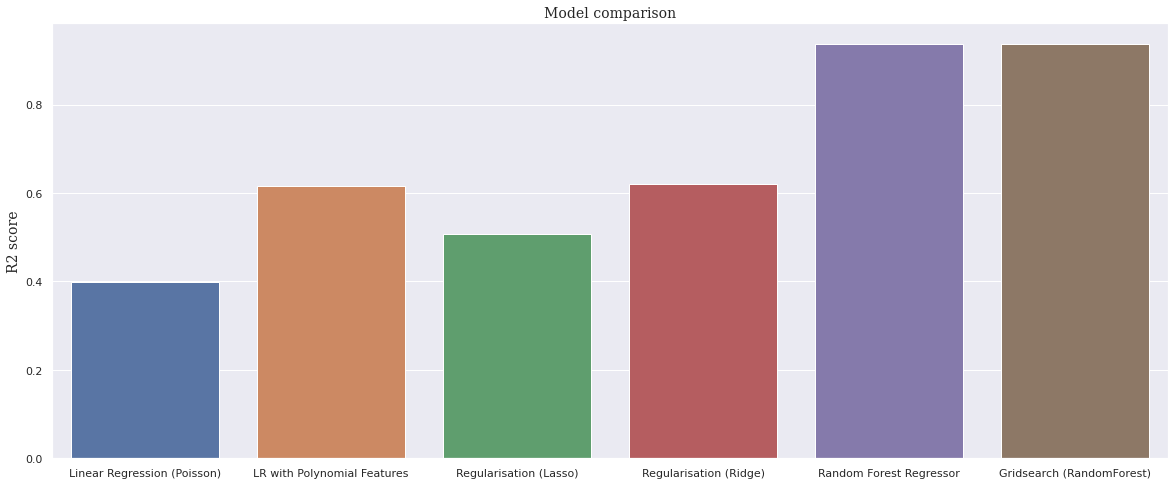

In [190]:
model_names = ['Linear Regression (Poisson)' , 'LR with Polynomial Features', 'Regularisation (Lasso)', 'Regularisation (Ridge)', 'Random Forest Regressor', 'Gridsearch (RandomForest)']
r2_scores = [r2_PoReg, r2_PoFe, r2_lasso, r2_ridge, r2_RaFo, r2_grid]

plt.figure(figsize = (20,8))
sns.barplot(x = model_names , y = r2_scores)
plt.title("Model comparison" , fontdict = {'family':'serif' , 'size':14})
plt.ylabel("R2 score" , fontdict = {'family':'serif' , 'size':14})

### 7.2. RMSLE scores

RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value increases in magnitude if the scale of error increases. 

Text(0, 0.5, 'RMSLE score')

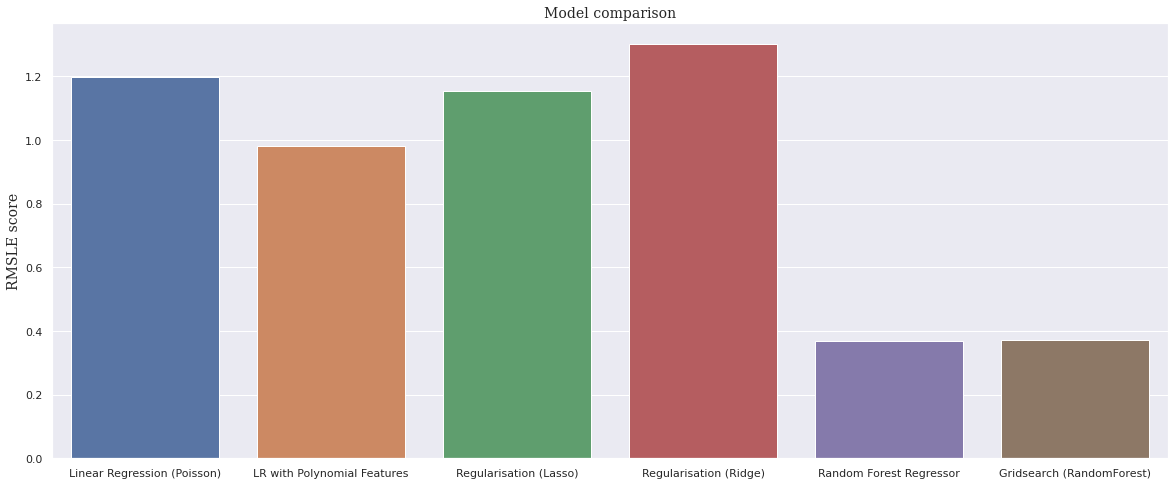

In [208]:
rmsle_scores = [rmsle_PoReg, rmsle_PoFe, rmsle_lasso, rmsle_ridge, rmsle_RaFo, rmsle_grid]

plt.figure(figsize = (20,8))
sns.barplot(x = model_names , y = rmsle_scores)
plt.title("Model comparison" , fontdict = {'family':'serif' , 'size':14})
plt.ylabel("RMSLE score" , fontdict = {'family':'serif' , 'size':14})

## 8. Submitting prediction to Kaggle

In [229]:
df_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


In [232]:
# Extracting hour, weekday, month and year from datetime 
df_test['hour'] = df_test.index.hour
df_test['weekday'] = df_test.index.weekday
df_test['month'] = df_test.index.month
df_test['year'] = df_test.index.year

In [239]:
df_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,3,1,2011
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,3,1,2011
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,3,1,2011
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3,1,2011
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,3,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,19,0,12,2012
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,20,0,12,2012
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,21,0,12,2012


In [241]:
# assigning X and y 
df_test = df_test.drop(['season', 'atemp'], axis=1)

In [242]:
X_submit = column_transformer.transform(df_test)

In [244]:
X_submit.shape

(6493, 32)

In [256]:
y_pred =  grid.best_estimator_.predict(X_submit)

In [257]:
predictions = pd.DataFrame({'dateTime': df_test.index, 'count': y_pred})
predictions.to_csv('predictions.csv',index=False) 

In [258]:
predictions.head(2)

,dateTime,count
0,2011-01-20 00:00:00,10.227407
1,2011-01-20 01:00:00,5.771942


Kaggle Score: 0.47210